### Imports

In [1]:
import os
import gc
import glob
import json
from collections import defaultdict
import multiprocessing as mp
from pathlib import Path
from types import SimpleNamespace
from typing import Dict, List, Optional, Tuple
import warnings
from importlib import reload

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas
import PIL.Image as Image
# disable PIL.DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = None

from sklearn.metrics import fbeta_score
from sklearn.exceptions import UndefinedMetricWarning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tqdm.auto import tqdm

%load_ext memory_profiler

### Set up data

In [2]:
BASE_PREFIX = 'data/' # change to your data folder
VALIDATION_RECTS = [(1100, 3500, 700, 950),  # validation patch to remove from each training fragment
                    (2200, 10800, 700, 950),
                    (2100, 4400, 700, 950)]
BUFFER = 30  # Buffer size in x and y direction
Z_START = 16 # First slice in the z direction to use
Z_DIM = 32   # Number of slices in the z direction
# TRAINING_EPOCHS = 30000
VALIDATION_EPOCHS = 1000
LEARNING_RATE = 0.03
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


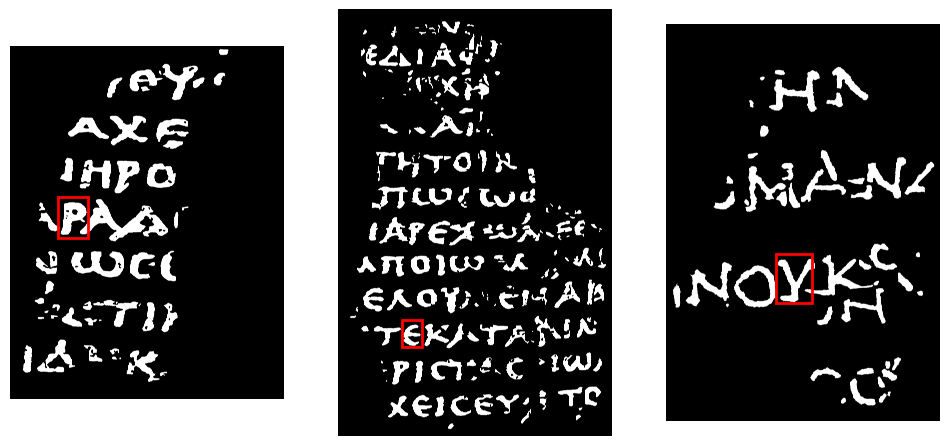

In [3]:
from utils import show_labels_with_rects
plt.figure(figsize=(12, 6))
show_labels_with_rects([1, 2, 3], BASE_PREFIX, VALIDATION_RECTS)

In [4]:
from utils import get_train_and_val_dsets

train_dset, val_dset = get_train_and_val_dsets(
    fragments_to_use=[1,2,3],
    data_path=BASE_PREFIX,
    z_start=Z_START,
    z_dim=Z_DIM,
    buffer=BUFFER,
    validation_rects=VALIDATION_RECTS,
    shuffle=True,
)
print("Num items (pixels) for training set:", len(train_dset))
print("Num items (pixels) for validation set:", len(val_dset))
print(train_dset[0])

Loading fragment 1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment 2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment 3:   0%|          | 0/32 [00:00<?, ?it/s]

Num items (pixels) for training set: 150176631
Num items (pixels) for validation set: 1999953
(tensor([[[[0.7076, 0.6518, 0.5304,  ..., 0.3504, 0.3486, 0.3385],
          [0.6918, 0.6383, 0.5176,  ..., 0.3630, 0.3554, 0.3462],
          [0.6369, 0.5892, 0.4754,  ..., 0.3770, 0.3805, 0.3828],
          ...,
          [0.2369, 0.1937, 0.1893,  ..., 0.4133, 0.4070, 0.3783],
          [0.2492, 0.1888, 0.1754,  ..., 0.3660, 0.3673, 0.3480],
          [0.2860, 0.2211, 0.1967,  ..., 0.3228, 0.3186, 0.2990]],

         [[0.6867, 0.6544, 0.5456,  ..., 0.3414, 0.3307, 0.3212],
          [0.6828, 0.6576, 0.5509,  ..., 0.3553, 0.3503, 0.3443],
          [0.6361, 0.6160, 0.5134,  ..., 0.3604, 0.3679, 0.3743],
          ...,
          [0.2965, 0.2044, 0.1699,  ..., 0.4731, 0.4599, 0.4202],
          [0.3088, 0.2082, 0.1700,  ..., 0.4343, 0.4263, 0.3960],
          [0.3389, 0.2432, 0.1955,  ..., 0.3882, 0.3749, 0.3479]],

         [[0.6433, 0.6288, 0.5341,  ..., 0.3558, 0.3294, 0.3198],
          [0.

In [5]:
train_loader = data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=False)
# Since we restart the iteration through the validation loader, it needs to be
# reshuffled.
val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=True)
print("Num of training batches:", len(train_loader))
print("Num of validation batches:", len(val_loader))

Num of training batches: 4693020
Num of validation batches: 62499


### Set up model

In [6]:
class InkDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()

        filters = [16, 32, 64]
        paddings = [1, 1, 1]
        kernel_sizes = [3, 3, 3]
        strides = [2, 2, 2]
        
        layers = []
        in_channels = 1
        for num_filters, padding, kernel_size, stride in zip(filters, paddings, kernel_sizes, strides):
            layers.extend([
                nn.Conv3d(
                    in_channels=in_channels,
                    out_channels=num_filters,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                ),
                nn.ReLU(inplace=True),
                torch.nn.BatchNorm3d(num_features=num_filters)
            ])
            in_channels = num_filters
        layers.append(nn.AdaptiveAvgPool3d(1))
        layers.append(nn.Flatten())

        self.encoder = nn.Sequential(*layers)
        self.decoder = nn.Sequential(
            nn.Linear(in_channels, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.decoder(features)

In [7]:
model = InkDetector().to(DEVICE)

### Train

In [8]:
TRAIN_RUN = False # To avoid re-running when saving the notebook

In [9]:
warnings.simplefilter('ignore', UndefinedMetricWarning)

In [10]:
from utils import Trainer, create_writer
TRAINING_EPOCHS = 60000
MODEL_SAVE_PATH = "trained_models/InkDetector_all_fragments_60k_epochs.pt"
if TRAIN_RUN:
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD
    
    
    # log to tensorboard
    writer = utils.create_writer(model_name=MODEL_SAVE_PATH)
    trainer = Trainer(model, train_loader, val_loader, optimizer, criterion, LEARNING_RATE, writer)
    
    trainer.train_eval_loop(TRAINING_EPOCHS, VALIDATION_EPOCHS)
    
    torch.save(model.state_dict(), MODEL_SAVE_PATH)

else:
    model_weights = torch.load(MODEL_SAVE_PATH)
    model.load_state_dict(model_weights)

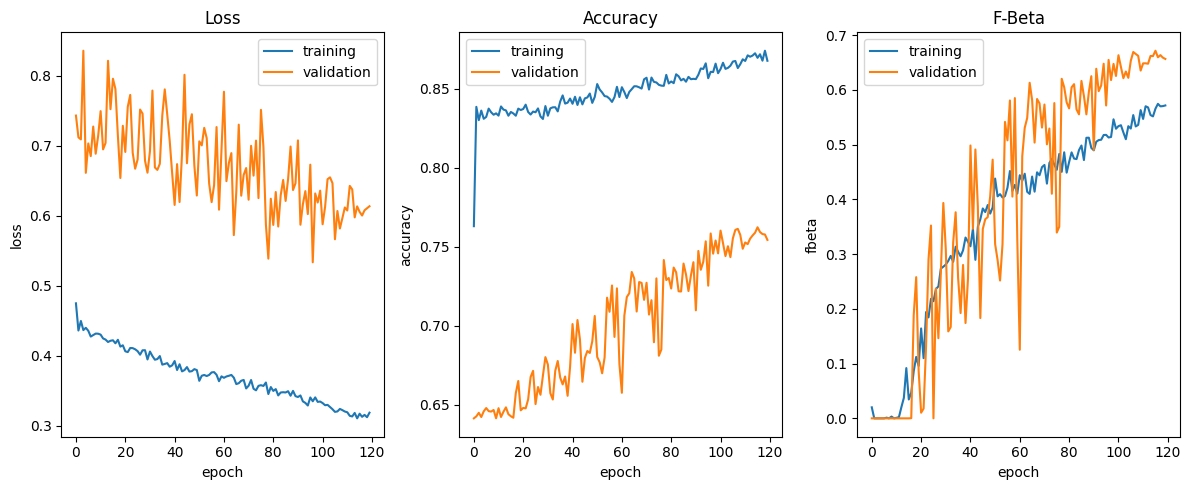

In [30]:
if TRAIN_RUN:
    plt.figure(figsize=(12, 5))
    trainer.plot_metrics()

This training loop:
- 60k epochs on all the data,
- running 1000 validation epochs every 500 training epochs,
- huffling the validation but not the training set,
took 36 minutes on my machine.

I think this is still not done converging after 60k epochs! Again, the validation set has higher $F_{0.5}$ than the training set for some reason. My guess is that that, since I chose the validation sets to be rectangles containing letters, the validation set has a higher proportion of ink than the training set, which biases its $F_{0.5}$ higher.

In [31]:
from utils import predict_validation_rects

fig = predict_validation_rects(model,
                               fragments_to_use=[1,2,3],
                               data_path=BASE_PREFIX,
                               z_start=Z_START,
                               z_dim=Z_DIM,
                               buffer=BUFFER,
                               validation_rects=VALIDATION_RECTS,
                               writer=writer)

Loading fragment 1:   0%|          | 0/32 [00:00<?, ?it/s]

Predicting on fragment 1:   0%|          | 0/20833 [00:00<?, ?it/s]

Loading fragment 2:   0%|          | 0/32 [00:00<?, ?it/s]

Predicting on fragment 2:   0%|          | 0/20833 [00:00<?, ?it/s]

Loading fragment 3:   0%|          | 0/32 [00:00<?, ?it/s]

Predicting on fragment 3:   0%|          | 0/20833 [00:00<?, ?it/s]

AttributeError: Figure.show works only for figures managed by pyplot, normally created by pyplot.figure()

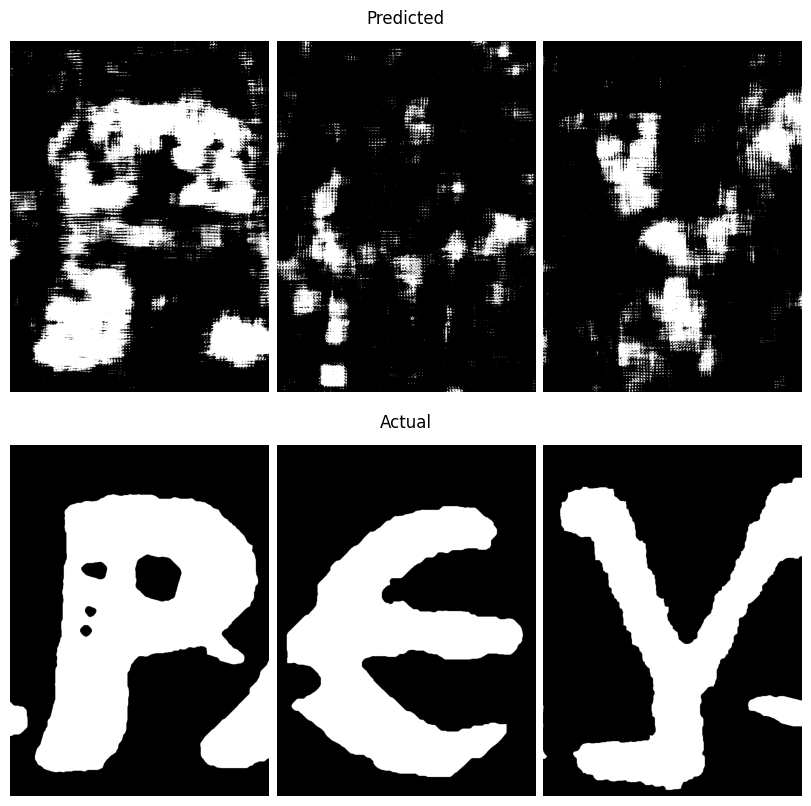

In [32]:
# show the figure (a little annoying: see this link--)
# https://stackoverflow.com/questions/49503869/attributeerror-while-trying-to-load-the-pickled-matplotlib-figure
dummy = plt.figure()
new_manager = dummy.canvas.manager
new_manager.canvas.figure = fig
fig.set_canvas(new_manager.canvas)

In [26]:
%load_ext tensorboard
%tensorboard --logdir logs --port 6004

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Question:** On fragments 1 and 3, the letter shape is at least recognizable, but not on fragment 2. Any idea why that would be?

#### Clean up before testing

In [13]:
print([x for x in dir() if not x.startswith('_')])

['BASE_PREFIX', 'BATCH_SIZE', 'BUFFER', 'DEVICE', 'Dict', 'Image', 'In', 'InkDetector', 'LEARNING_RATE', 'List', 'MODEL_SAVE_PATH', 'Optional', 'Out', 'Path', 'SimpleNamespace', 'TRAINING_EPOCHS', 'TRAIN_RUN', 'Trainer', 'Tuple', 'UndefinedMetricWarning', 'VALIDATION_EPOCHS', 'VALIDATION_RECTS', 'Z_DIM', 'Z_START', 'create_writer', 'data', 'defaultdict', 'exit', 'fbeta_score', 'gc', 'get_ipython', 'get_train_and_val_dsets', 'glob', 'json', 'model', 'model_weights', 'mp', 'nn', 'np', 'open', 'optim', 'os', 'pandas', 'patches', 'plt', 'quit', 'reload', 'show_labels_with_rects', 'test_fragments', 'test_path', 'torch', 'tqdm', 'train_dset', 'train_loader', 'val_dset', 'val_loader', 'warnings']


In [14]:
# Clear memory before loading test fragments
to_delete = [
    'image_stack',
    'train_dset',
    'train_dsets',
    'train_loader',
    'val_dset',
    'val_dsets',
    'val_loader'
]
for name in to_delete:
    if name in dir():
        exec('del ' + name)
gc.collect()

9583

#### Testing

In [12]:
test_path = Path(BASE_PREFIX) / "test"
test_fragments = [p.stem for p in test_path.iterdir()]
print("All fragments:", test_fragments)

All fragments: ['a', 'b']


In [26]:
import utils
reload(utils)
reload(utils.data_preparation)
reload(utils)

<module 'utils' from '/home/pvk/Documents/python/ML/scrolls/utils/__init__.py'>

In [30]:
# Predict on test fragments
from utils.data_preparation import get_rect_dset
DECISION_BOUNDARY = 0.4

pred_images = []
model.eval()
for test_fragment in test_fragments:
    outputs = []
    test_dset = get_rect_dset(test_fragment, BASE_PREFIX, z_start=Z_START,
                              z_dim=Z_DIM, buffer=BUFFER)
    test_loader = data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False)
    with torch.no_grad():
        for i, (subvolumes, _) in enumerate(tqdm(test_loader, desc=f"Predicting on fragment {test_fragment}"):
            output = model(subvolumes.to(DEVICE)).view(-1).sigmoid().cpu().numpy()
            outputs.append(output)
    image_shape = eval_dset.image_stack[0].shape
    
    # clean up
    test_dset.image_stack = None
    del test_loader
    gc.collect()

    pred_image = np.zeros(image_shape, dtype=np.uint8)
    outputs = np.concatenate(outputs)
    for (y, x, _), prob in zip(test_dset.pixels[:outputs.shape[0]], outputs):
        pred_image[y, x] = prob > DECISION_BOUNDARY
    pred_images.append(pred_image)
    
    eval_dset.pixels = None
    del eval_dset
    gc.collect()
    print("Finished with fragment", test_fragment)

Loading fragment a:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/334662 [00:00<?, ?it/s]

TypeError: 'desc' is an invalid keyword argument for enumerate()

### Submission

In [ ]:
def rle(output):
    flat_img = np.where(output > 0.4, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

In [ ]:
submission = defaultdict(list)
for fragment_id, fragment_name in enumerate(test_fragments):
    submission["Id"].append(fragment_name.name)
    submission["Predicted"].append(rle(pred_images[fragment_id]))


In [ ]:
pd.DataFrame.from_dict(submission).to_csv("/kaggle/working/submission.csv", index=False)
pd.DataFrame.from_dict(submission)